In [1]:
!pip install scikit-plot

In [2]:
!pip install dask-ml

In [3]:
!pip install pyod

In [4]:
!pip install imbalanced-learn

In [5]:
!pip install fastparquet

In [6]:
!pip install scikit-plot

In [7]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sys 
#Sklearn
from sklearn.metrics import *
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#Imbalanced learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, OneSidedSelection
from imblearn.pipeline import Pipeline, make_pipeline
#Dask et Parquet
import dask.dataframe as dd 
import fastparquet
from dask_ml.preprocessing import DummyEncoder
import pickle
import dask_ml 
from dask import delayed
from dask_ml.preprocessing import StandardScaler

In [8]:
os.chdir('C:\\Users\\cornuch\\Desktop\\SISE\\Fouille_donnees_massives\\projet_fouille')

# 1. Importation des fichiers et préparation

## 1.1 Importation

In [9]:
df_train=dd.read_parquet('train_fast')
df_train.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,7
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61,7
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00,7
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00,7
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25,8


In [10]:
df_test=dd.read_parquet('test_fast')
df_test.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
3899362,0,60.00,0,302,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00,7
3899363,0,25.00,0,547,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00,8
3899364,0,32.00,0,152,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00,8
3899365,0,20.88,0,393,0.007590,0.182221,0.002092,34.118277,4,1,1.539155,71.51,8
3899366,0,20.21,0,152,0.018994,-1.024399,0.005682,52.076034,0,1,4.000000,0.00,8


In [11]:
# Définir la variable cible 
y_train = df_train["FlagImpaye"]
y_test = df_test["FlagImpaye"]

In [12]:
# Définir les variables explicatives 
X_train = df_train.drop(["FlagImpaye"], axis = "columns")
X_test = df_test.drop(["FlagImpaye"], axis = "columns")

## 1.2 Centrage et réduction

In [13]:
# Instanciation de StandardScaler pour centrer-réduire les données
scaler = StandardScaler()

In [14]:
# Centrer-réduire les dataframe d'apprentissage
X_train_scale = scaler.fit_transform(X_train)
X_train_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
0,-0.420302,-0.581824,1.017656,-0.084590,-0.239505,-0.275801,0.818043,-0.043817,-0.194165,-0.451325,-0.202861,-2.122399
1,-0.420302,-0.581824,1.017656,-0.084590,-0.239505,-0.275801,0.818043,-0.043812,4.975724,-0.451325,0.038808,-2.122399
2,-0.022127,-0.581824,1.008573,-0.084590,-0.239505,-0.275801,0.818043,-0.043817,-0.194165,-0.451325,-0.202861,-2.122399
3,-0.057565,1.545332,-0.272152,-0.084590,-0.239505,-0.275801,0.906727,-0.043817,-0.194165,-0.451325,-0.202861,-2.122399
4,-0.347310,-0.581824,1.008573,-0.084434,0.637044,-0.273204,0.818043,-0.043812,-0.194165,-0.451325,0.702346,-1.820898


In [15]:
# Centrer-réduire les dataframe de test
X_test_scale = scaler.fit_transform(X_test)
X_test_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR,Heure_num
3899362,-0.016999,0.0,0.265719,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-2.235916
3899363,-0.277531,0.0,1.427785,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-1.929154
3899364,-0.225425,0.0,-0.445750,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-1.929154
3899365,-0.308200,0.0,0.697344,-0.080074,-0.023966,-0.314458,-0.277090,-0.036897,-0.18432,-5.906429,1.259186,-1.929154
3899366,-0.313187,0.0,-0.445750,-0.079781,-0.156360,-0.308551,0.774799,-0.036921,-0.18432,-0.568544,-0.132257,-1.929154


## 1.3 Modification du seuil d'affectation 

In [16]:
from numpy import arange
from numpy import argmax

In [17]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

In [18]:
def modif_seuil(classifier,X_test_scale,y_test):
    # predict probabilities
    yhat = delayed(classifier.predict_proba)(X_test_scale).compute()
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0.1, 1, 0.1)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    s=('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return s

Dans le cas où on conserve les données de départ sans startégie d'échantillonnage :
Si la courbe ROC tient la route avec un critère AUC éleve, cela signifie que l'apprentissage a bien fonctionné
Si le F1_score est très mauvais, cela signifie alors que c'est le processus d'affectation qui n'a pas fonctionné
On cherchera alors à effectuer un post-traitement en modifiant le seuil d'affectation

# 2. Mesures de performances

**Maximisation de la marge**

In [19]:
def perte(Montant):
    if Montant<=20:
        Montant=Montant*0
    elif 20<Montant<=50:
        Montant=0.2*Montant
    elif 50<Montant<=100:
        Montant=0.3*Montant
    elif 100<Montant<=200:
        Montant=0.5*Montant
    elif Montant>200:
        Montant=0.8*Montant
    return(Montant)

In [20]:
def Calcul_Marge(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable Marge
    # Création d'une colonne Marge égale au Montant
    dfmerge["Marge"] = dfmerge["Montant"]
    #Calcul du gain ou de la perte selon la différence entre réel et prédiction
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "Marge"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "Marge"] = 0.7 * 0.05 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "Marge"] = dfmerge["Montant"].apply(lambda x: -perte(x))
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 0)), "Marge"] = 0.05 * dfmerge["Montant"]
    
    # Calcul du Marge_totale
    Marge_totale = dfmerge["Marge"].sum()
    
    return Marge_totale

In [21]:
# Création de la fonction de performance d'un modèle sur les données de test

def performances(modele, X_test, y_test, scale):
    
    X_test_ = X_test
    
    print("-------------------------------------------------------")
  
    if scale == True:
        X_test = scaler.transform(X_test) # scaler a été entrainé sur les données d'apprentissage
        
    # Affichage du modèle 
    print('Modèle :\n', modele)
    print("-------------------------------------------------------")
    # Prédiction
    y_pred = delayed(modele.predict)(X_test).compute()
    # Prédiction des scores
    y_score = delayed(modele.predict_proba)(X_test).compute()
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(y_test, y_pred).compute()
    cr = delayed(classification_report)(y_test, y_pred).compute()
    auc = delayed(roc_auc_score)(y_test, y_pred).compute()
    f1 = delayed(f1_score)(y_test, y_pred).compute()
   
    print('F1_score :\n', f1)
    print("-------------------------------------------------------")
    print('Estimateurs :\n', cr)
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm)
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc)
    print("-------------------------------------------------------")
    
    #Calcul de la Marge
    Marge_totale = Calcul_Marge(Montant = X_test_["Montant"].compute(), yReel = y_test.compute(), yPred = y_pred)
    print("Marge = " + str(round(Marge_totale, 2)) + " euros")
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(y_test, y_score, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(y_test, y_score, classes_to_plot = 1, plot_micro = False)

    #return y_score,Marge_totale,auc,cr,cm

# 3. Algorithmes testés

## 3.1 Regression linéaire "de base"

In [22]:
%%time

#instanciation du modèle
clf0 = LogisticRegression(random_state=0)

#Structure de l'entrainement 
classifier0=delayed(clf0.fit)(X_train_scale, y_train).compute()

CPU times: total: 34.7 s
Wall time: 11.2 s


-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0)
-------------------------------------------------------
F1_score :
 0.0006067961165048543
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.11      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.55      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740820     17]
 [  6571      2]]
-------------------------------------------------------
Auc Score :
 0.5001406640233118
-------------------------------------------------------
Marge = 1940083.62 euros
-------------------------------------------------------
CPU times: total: 7.27 s
Wall time: 5.35 s


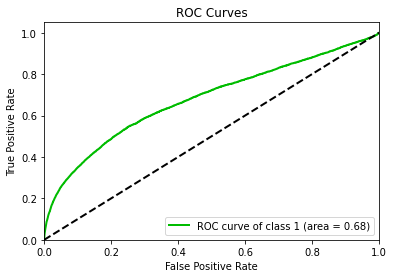

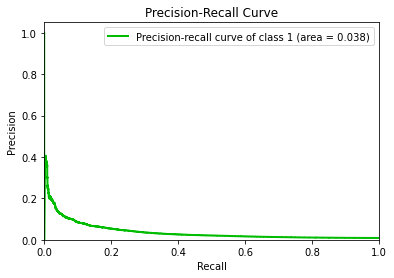

In [23]:
%%time
#Calculs des performances du modèles
performances(classifier0, X_test, y_test,scale=True)

Résultats catastrophiques en terme de performances du f1-score et du critère AUC, on va essayer d'utiliser SMOTE et le solveur saga indiquer dans le cas des données volumineuses et qui accepte elasticnet. Attention saga ne converge que si les deux échnatillons sont à peu près de même taille.

## 3.2 En utilisant SMOTE 

In [24]:
%%time

#Oversampling
resampling1 = SMOTE(random_state=0)

#instanciation du modèle
model1 = LogisticRegression(solver='saga',random_state=0)

# Definir une pipeline, indiquer de combiner SMOTE avec le modèle de Régression Logistique
clf1 = Pipeline([('SMOTE', resampling1), ('Logistic Regression', model1)])

#Structure de l'entrainement 
classifier1=delayed(clf1.fit)(X_train_scale, y_train).compute()

CPU times: total: 1min 35s
Wall time: 1min 34s


-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.03964035964035963
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.78      0.87    740837
           1       0.02      0.53      0.04      6573

    accuracy                           0.77    747410
   macro avg       0.51      0.65      0.46    747410
weighted avg       0.99      0.77      0.87    747410

-------------------------------------------------------
Matrice de confusion :
 [[575707 165130]
 [  3101   3472]]
-------------------------------------------------------
Auc Score :
 0.652662488825871
-------------------------------------------------------
Marge = 2013968.66 euros
-----

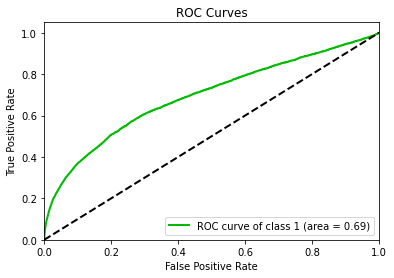

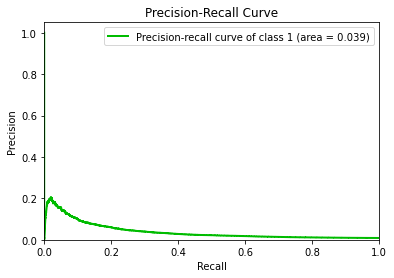

In [25]:
%%time
#Calculs des performances du modèles
performances(classifier1, X_test, y_test,scale=True)

Nous avons amélioré le f1-score, le critère AUC et la marge.
Nous allons essayer d'améliorer ces performances utilisant BorderlineSMOTE qui se focalise sur les points mal classés.

## 3.2 Régression logistique avec BorderlineSMOTE

In [26]:
%%time

#Oversampling
resampling2 = BorderlineSMOTE(random_state=0)

#instanciation du modèle
model1 = LogisticRegression(solver='saga',random_state=0)

# Definir une pipeline, indiquer de combiner SMOTE avec le modèle de Régression Logistique
clf2 = Pipeline([('BorderlineSMOTE', resampling2), ('Logistic Regression', model1)])

#Structure de l'entrainement 
classifier2=delayed(clf2.fit)(X_train_scale, y_train).compute()

CPU times: total: 2min 37s
Wall time: 2min 37s


-------------------------------------------------------
Modèle :
 Pipeline(steps=[('BorderlineSMOTE', BorderlineSMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.041140224168510355
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    740837
           1       0.02      0.51      0.04      6573

    accuracy                           0.79    747410
   macro avg       0.51      0.65      0.46    747410
weighted avg       0.99      0.79      0.87    747410

-------------------------------------------------------
Matrice de confusion :
 [[586712 154125]
 [  3198   3375]]
-------------------------------------------------------
Auc Score :
 0.652711228315999
-------------------------------------------------------
Marge = 2

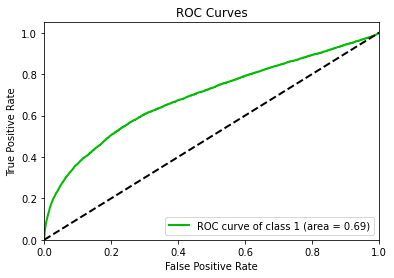

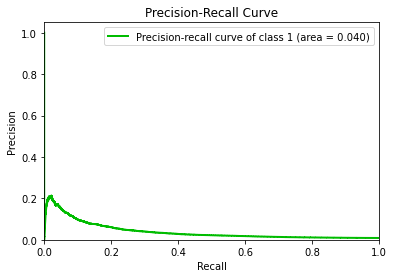

In [27]:
%%time
#Calculs des performances du modèles
performances(classifier2, X_test, y_test,scale=True)

Les résultats sont améliorés au niveau du f1-score et de la marge. Nous allons essayer de les améliorer encore en utilisant une régréssion avec C=0,01 et elasticnet.

In [28]:
%%time

#Oversampling
resampling3 = ADASYN(random_state=0)

#instanciation du modèle
model1 = LogisticRegression(solver='saga',random_state=0)

# Definir une pipeline, indiquer de combiner SMOTE avec le modèle de Régression Logistique
clf3 = Pipeline([('ADASYN', resampling3), ('Logistic Regression', model1)])

#Structure de l'entrainement 
classifier3=delayed(clf3.fit)(X_train_scale, y_train).compute()

CPU times: total: 2min 44s
Wall time: 2min 43s


-------------------------------------------------------
Modèle :
 Pipeline(steps=[('ADASYN', ADASYN(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.03875833424417969
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    740837
           1       0.02      0.54      0.04      6573

    accuracy                           0.76    747410
   macro avg       0.51      0.65      0.45    747410
weighted avg       0.99      0.76      0.86    747410

-------------------------------------------------------
Matrice de confusion :
 [[567976 172861]
 [  3027   3546]]
-------------------------------------------------------
Auc Score :
 0.6530738305682691
-------------------------------------------------------
Marge = 2009300.84 euros
--

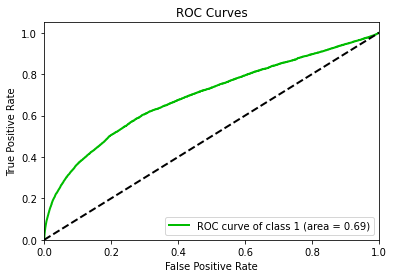

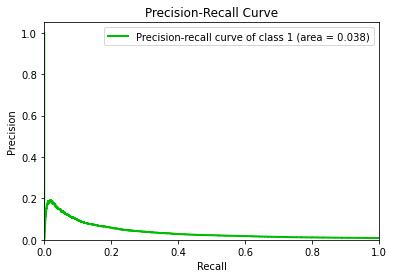

In [29]:
%%time
#Calculs des performances du modèles
performances(classifier3, X_test, y_test,scale=True)

## 3.2 Régression logistique avec BorderlineSMOTE et régularisation (C=0,01 et Elasticnet)

In [32]:
%%time

#Oversampling
resampling2 = BorderlineSMOTE(random_state=0)

#instanciation du modèle
model2 = LogisticRegression(random_state=0, penalty='elasticnet', l1_ratio=0.5, solver='saga', C=0.01, max_iter=100)

# Definir une pipeline, indiquer de combiner SMOTE avec le modèle de Régression Logistique
clf5 = Pipeline([('SMOTE', resampling2), ('Logistic Regression', model2)])

#Structure de l'entrainement 
classifier5=delayed(clf5.fit)(X_train_scale, y_train).compute()

CPU times: total: 6min 9s
Wall time: 3min 4s


-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', BorderlineSMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet',
                                    random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.04114047491345263
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    740837
           1       0.02      0.51      0.04      6573

    accuracy                           0.79    747410
   macro avg       0.51      0.65      0.46    747410
weighted avg       0.99      0.79      0.87    747410

-------------------------------------------------------
Matrice de confusion :
 [[586713 154124]
 [  3198   3375]]
-------------------------------------------------------
Auc Score :
 0.652711903228

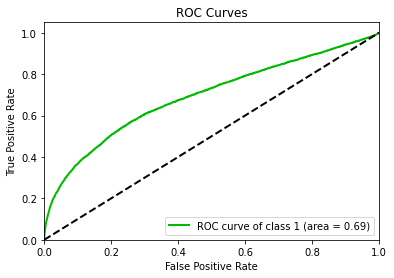

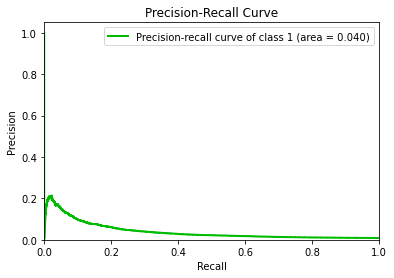

In [33]:
%%time
#Calculs des performances du modèles
performances(classifier5, X_test, y_test,scale=True)

Le f1_score est amélioré, en revanche ni le critère AUC, ni la maximisation de la marge ne bénéficie de cette modification.

## 3.3 Régression Logistique sans stratégie d'échantillonnage mais un class_weight balanced

In [34]:
%%time

#instanciation du modèle
clf6 = LogisticRegression(random_state=0,class_weight='balanced')

#Structure de l'entrainement 
classifier6=delayed(clf6.fit)(X_train_scale, y_train).compute()

CPU times: total: 32.3 s
Wall time: 8.86 s


-------------------------------------------------------
Modèle :
 LogisticRegression(class_weight='balanced', random_state=0)
-------------------------------------------------------
F1_score :
 0.03996314637797996
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      0.78      0.87    740837
           1       0.02      0.53      0.04      6573

    accuracy                           0.78    747410
   macro avg       0.51      0.65      0.46    747410
weighted avg       0.99      0.78      0.87    747410

-------------------------------------------------------
Matrice de confusion :
 [[577220 163617]
 [  3103   3470]]
-------------------------------------------------------
Auc Score :
 0.6535314935960995
-------------------------------------------------------
Marge = 2013481.83 euros
-------------------------------------------------------
CPU times: total: 13.4 s
Wall time: 5.75 s


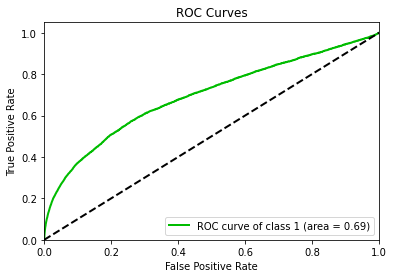

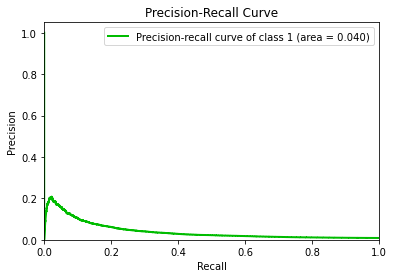

In [35]:
%%time
#Calculs des performances du modèles
performances(classifier6, X_test, y_test,scale=True)

In [38]:
%%time
seuil=modif_seuil(classifier3,X_test_scale,y_test)
seuil

CPU times: total: 19.1 s
Wall time: 8.97 s


'Threshold=0.800, F-Score=0.09809'

**Visualisation de l'importance des variables pour le meilleur modèle de regression linéaire**

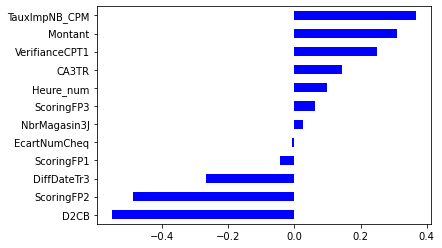

In [37]:
importances = pd.Series(clf6.coef_[0], index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()